In [1]:
import pandas as pd, numpy as np
from datetime import datetime
# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

https://pypi.org/project/yfinance/

# 1. Extracting Data

ETF基金分为以下几类：

一、QDII基金：QD基金是指国内投资者对海外资本市场进行投资的一种基金。目前国内的QDII基金主要投资美股市场、港股市场，典型代表有华宝油气（162411）、标普500（513500）和香港中小（501021）等。

二、场内货币ETF：场内货币ETF指的是可以交易的货币基金。相比于普通的货币基金，此类基金在交易所上市，可以进行买卖和申赎。场内货币基金的买卖就和股票的操作一样，直接输入交易代码填写数量即可。场内货币ETF的典型代表有华宝添益（511990）、银华日利（511880）、建信添益（511660）等。

三、黄金ETF：黄金ETF指的是投资黄金的指数基金，跟踪的是现货黄金的价格波动。目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。

四、指数ETF：指数ETF是这四类ETF基金中数量最多、最常见的ETF金了。股民们熟悉的300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、军工ETF（512660）、广发医药（159938）等。

In [9]:
today = str(datetime.now().date())

def get_data(code,start='20100101',end=today):
    df = ts.pro_bar(ts_code=code, adj='qfq', start_date=start, end_date=end)
    return df

#获取当前交易日最新的股票代码和简称
def get_code():
    codes = pro.stock_basic(list_status='L').ts_code.values
    return codes

#设置token
token='2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67'
pro = ts.pro_api(token)
codes = get_code()

In [10]:
len(codes)

3741

In [5]:
# ts.pro_bar(ts_code="513500", adj='qfq', start_date="2019-01-01", end_date="2019-08-01")

In [11]:
import eventlet
eventlet.monkey_patch()

ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

ticker_list = codes
# ticker_list = ['513500',#标普500
#                '501021',#香港中小
#                # 目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。
#                '159934','159937','518800','518880'
#                # 300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。
#                # 除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、
#                # 军工ETF（512660）、广发医药（159938）等。
#                '510300','159915','510500','510230','512800','512660','159938']
today = str(datetime.now().date())
start = '2010-01-01'
end = today
for ticker in ticker_list:
    if not os.path.exists(ch_db_path+ticker+".csv"):
        print("{} is new, start downloading now...".format(ticker))
        try:
            data = get_data(ticker)
            data['trade_date'] = data['trade_date'].astype(str)
            data['trade_date'] = data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
            data.sort_values("trade_date", inplace = True)
            data.to_csv(ch_db_path+ticker+".csv", index = False)
            print("{} data file created: {}".format(ticker, end))
        except Exception as e:
            print(e)
            
    else:
        print("Already have data csv for {}".format(ticker))
        hist_data = pd.read_csv(ch_db_path+ticker+".csv")   
        try:
            hist_data_last_date = hist_data['trade_date'].values[-1]        
            if today > hist_data_last_date:
                print("Needs to update, start updating new data for {} now...".format(ticker))
                update_start = hist_data_last_date
                update_end = today
                with eventlet.Timeout(60,False):
                    try:
                        new_data = get_data(ticker, update_start, update_end)
                        new_data['trade_date'] = new_data['trade_date'].astype(str)
                        new_data['trade_date'] = new_data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
                        new_data.to_csv(ch_db_path+ticker+".csv", mode='a', header=False, index = False)
                        updated_duplicated_df = pd.read_csv(ch_db_path+ticker+".csv")
                        updated_df = updated_duplicated_df.drop_duplicates("trade_date")
                        updated_df.sort_values("trade_date", inplace = True)
                        updated_df.to_csv(ch_db_path+ticker+".csv", index = False)
                        print("New data updated till today for {}!".format(ticker))
                    except Exception as e:
                        print(e)
    #             print("Timed Out: Update Failed!")
            else:
                print("There's no new data to update for {}.".format(ticker))
        except Exception as e:
            print(e)

#     print("Data Download/Update for {} is Finished.".format(ticker))
    print("===============================================")
    
print("【Updated Finished for today!】")

Already have data csv for 000001.SZ
There's no new data to update for 000001.SZ.
Already have data csv for 000002.SZ
Needs to update, start updating new data for 000002.SZ now...


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


New data updated till today for 000002.SZ!
Already have data csv for 000004.SZ
Needs to update, start updating new data for 000004.SZ now...
New data updated till today for 000004.SZ!
Already have data csv for 000005.SZ
Needs to update, start updating new data for 000005.SZ now...
New data updated till today for 000005.SZ!
Already have data csv for 000006.SZ
Needs to update, start updating new data for 000006.SZ now...
New data updated till today for 000006.SZ!
Already have data csv for 000007.SZ
Needs to update, start updating new data for 000007.SZ now...
New data updated till today for 000007.SZ!
Already have data csv for 000008.SZ
Needs to update, start updating new data for 000008.SZ now...
New data updated till today for 000008.SZ!
Already have data csv for 000009.SZ
Needs to update, start updating new data for 000009.SZ now...
New data updated till today for 000009.SZ!
Already have data csv for 000010.SZ
Needs to update, start updating new data for 000010.SZ now...
New data upda

New data updated till today for 000061.SZ!
Already have data csv for 000062.SZ
Needs to update, start updating new data for 000062.SZ now...
New data updated till today for 000062.SZ!
Already have data csv for 000063.SZ
Needs to update, start updating new data for 000063.SZ now...
New data updated till today for 000063.SZ!
Already have data csv for 000065.SZ
Needs to update, start updating new data for 000065.SZ now...
New data updated till today for 000065.SZ!
Already have data csv for 000066.SZ
Needs to update, start updating new data for 000066.SZ now...
New data updated till today for 000066.SZ!
Already have data csv for 000068.SZ
Needs to update, start updating new data for 000068.SZ now...
New data updated till today for 000068.SZ!
Already have data csv for 000069.SZ
Needs to update, start updating new data for 000069.SZ now...
New data updated till today for 000069.SZ!
Already have data csv for 000070.SZ
Needs to update, start updating new data for 000070.SZ now...
New data upda

New data updated till today for 000422.SZ!
Already have data csv for 000423.SZ
Needs to update, start updating new data for 000423.SZ now...
New data updated till today for 000423.SZ!
Already have data csv for 000425.SZ
Needs to update, start updating new data for 000425.SZ now...
New data updated till today for 000425.SZ!
Already have data csv for 000426.SZ
Needs to update, start updating new data for 000426.SZ now...
New data updated till today for 000426.SZ!
Already have data csv for 000428.SZ
Needs to update, start updating new data for 000428.SZ now...
New data updated till today for 000428.SZ!
Already have data csv for 000429.SZ
Needs to update, start updating new data for 000429.SZ now...
New data updated till today for 000429.SZ!
Already have data csv for 000430.SZ
Needs to update, start updating new data for 000430.SZ now...
New data updated till today for 000430.SZ!
Already have data csv for 000488.SZ
Needs to update, start updating new data for 000488.SZ now...
New data upda

New data updated till today for 000544.SZ!
Already have data csv for 000545.SZ
Needs to update, start updating new data for 000545.SZ now...
New data updated till today for 000545.SZ!
Already have data csv for 000546.SZ
Needs to update, start updating new data for 000546.SZ now...
New data updated till today for 000546.SZ!
Already have data csv for 000547.SZ
Needs to update, start updating new data for 000547.SZ now...
New data updated till today for 000547.SZ!
Already have data csv for 000548.SZ
Needs to update, start updating new data for 000548.SZ now...
New data updated till today for 000548.SZ!
Already have data csv for 000550.SZ
Needs to update, start updating new data for 000550.SZ now...
New data updated till today for 000550.SZ!
Already have data csv for 000551.SZ
Needs to update, start updating new data for 000551.SZ now...
New data updated till today for 000551.SZ!
Already have data csv for 000552.SZ
Needs to update, start updating new data for 000552.SZ now...
New data upda

New data updated till today for 000601.SZ!
Already have data csv for 000603.SZ
Needs to update, start updating new data for 000603.SZ now...
New data updated till today for 000603.SZ!
Already have data csv for 000605.SZ
Needs to update, start updating new data for 000605.SZ now...
New data updated till today for 000605.SZ!
Already have data csv for 000606.SZ
Needs to update, start updating new data for 000606.SZ now...
New data updated till today for 000606.SZ!
Already have data csv for 000607.SZ
Needs to update, start updating new data for 000607.SZ now...
New data updated till today for 000607.SZ!
Already have data csv for 000608.SZ
Needs to update, start updating new data for 000608.SZ now...
New data updated till today for 000608.SZ!
Already have data csv for 000609.SZ
Needs to update, start updating new data for 000609.SZ now...
New data updated till today for 000609.SZ!
Already have data csv for 000610.SZ
Needs to update, start updating new data for 000610.SZ now...
New data upda

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000655.SZ
Needs to update, start updating new data for 000655.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000656.SZ
Needs to update, start updating new data for 000656.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000657.SZ
Needs to update, start updating new data for 000657.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000683.SZ
Needs to update, start updating new data for 000683.SZ now...
New data updated till today for 000683.SZ!
Already have data csv for 000685.SZ
Needs to update, start updating new data for 000685.SZ now...
New data updated till today for 000685.SZ!
Already have data csv for 000686.SZ
Needs to update, start updating new data for 000686.SZ now...
New data updated till today for 000686.SZ!
Already have data csv for 000687.SZ
Needs to update, start updating new data for 000687.SZ now...
New data updated till today for 000687.SZ!
Already have data csv for 000688.SZ
Needs to update, start updating new data for 000688.SZ now...
New data updated till today for 000688.SZ!
Already have data csv for 000690.SZ
Needs to update, start updating new 

New data updated till today for 000737.SZ!
Already have data csv for 000738.SZ
Needs to update, start updating new data for 000738.SZ now...
New data updated till today for 000738.SZ!
Already have data csv for 000739.SZ
Needs to update, start updating new data for 000739.SZ now...
New data updated till today for 000739.SZ!
Already have data csv for 000750.SZ
Needs to update, start updating new data for 000750.SZ now...
New data updated till today for 000750.SZ!
Already have data csv for 000751.SZ
Needs to update, start updating new data for 000751.SZ now...
New data updated till today for 000751.SZ!
Already have data csv for 000752.SZ
Needs to update, start updating new data for 000752.SZ now...
New data updated till today for 000752.SZ!
Already have data csv for 000753.SZ
Needs to update, start updating new data for 000753.SZ now...
New data updated till today for 000753.SZ!
Already have data csv for 000755.SZ
Needs to update, start updating new data for 000755.SZ now...
New data upda

New data updated till today for 000809.SZ!
Already have data csv for 000810.SZ
Needs to update, start updating new data for 000810.SZ now...
New data updated till today for 000810.SZ!
Already have data csv for 000811.SZ
Needs to update, start updating new data for 000811.SZ now...
New data updated till today for 000811.SZ!
Already have data csv for 000812.SZ
Needs to update, start updating new data for 000812.SZ now...
New data updated till today for 000812.SZ!
Already have data csv for 000813.SZ
Needs to update, start updating new data for 000813.SZ now...
New data updated till today for 000813.SZ!
Already have data csv for 000815.SZ
Needs to update, start updating new data for 000815.SZ now...
New data updated till today for 000815.SZ!
Already have data csv for 000816.SZ
Needs to update, start updating new data for 000816.SZ now...
New data updated till today for 000816.SZ!
Already have data csv for 000818.SZ
Needs to update, start updating new data for 000818.SZ now...
New data upda

New data updated till today for 000882.SZ!
Already have data csv for 000883.SZ
Needs to update, start updating new data for 000883.SZ now...
New data updated till today for 000883.SZ!
Already have data csv for 000885.SZ
Needs to update, start updating new data for 000885.SZ now...
New data updated till today for 000885.SZ!
Already have data csv for 000886.SZ
Needs to update, start updating new data for 000886.SZ now...
New data updated till today for 000886.SZ!
Already have data csv for 000887.SZ
Needs to update, start updating new data for 000887.SZ now...
New data updated till today for 000887.SZ!
Already have data csv for 000888.SZ
Needs to update, start updating new data for 000888.SZ now...
New data updated till today for 000888.SZ!
Already have data csv for 000889.SZ
Needs to update, start updating new data for 000889.SZ now...
New data updated till today for 000889.SZ!
Already have data csv for 000890.SZ
Needs to update, start updating new data for 000890.SZ now...
New data upda

New data updated till today for 000936.SZ!
Already have data csv for 000937.SZ
Needs to update, start updating new data for 000937.SZ now...
New data updated till today for 000937.SZ!
Already have data csv for 000938.SZ
Needs to update, start updating new data for 000938.SZ now...
New data updated till today for 000938.SZ!
Already have data csv for 000948.SZ
Needs to update, start updating new data for 000948.SZ now...
New data updated till today for 000948.SZ!
Already have data csv for 000949.SZ
Needs to update, start updating new data for 000949.SZ now...
New data updated till today for 000949.SZ!
Already have data csv for 000950.SZ
Needs to update, start updating new data for 000950.SZ now...
New data updated till today for 000950.SZ!
Already have data csv for 000951.SZ
Needs to update, start updating new data for 000951.SZ now...
New data updated till today for 000951.SZ!
Already have data csv for 000952.SZ
Needs to update, start updating new data for 000952.SZ now...
New data upda

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000987.SZ
Needs to update, start updating new data for 000987.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000988.SZ
Needs to update, start updating new data for 000988.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 000989.SZ
Needs to update, start updating new data for 000989.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002009.SZ
Needs to update, start updating new data for 002009.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002010.SZ
Needs to update, start updating new data for 002010.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002011.SZ
Needs to update, start updating new data for 002011.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

New data updated till today for 002048.SZ!
Already have data csv for 002049.SZ
Needs to update, start updating new data for 002049.SZ now...
New data updated till today for 002049.SZ!
Already have data csv for 002050.SZ
Needs to update, start updating new data for 002050.SZ now...
New data updated till today for 002050.SZ!
Already have data csv for 002051.SZ
Needs to update, start updating new data for 002051.SZ now...
New data updated till today for 002051.SZ!
Already have data csv for 002052.SZ
Needs to update, start updating new data for 002052.SZ now...
New data updated till today for 002052.SZ!
Already have data csv for 002053.SZ
Needs to update, start updating new data for 002053.SZ now...
New data updated till today for 002053.SZ!
Already have data csv for 002054.SZ
Needs to update, start updating new data for 002054.SZ now...
New data updated till today for 002054.SZ!
Already have data csv for 002055.SZ
Needs to update, start updating new data for 002055.SZ now...
New data upda

New data updated till today for 002093.SZ!
Already have data csv for 002094.SZ
Needs to update, start updating new data for 002094.SZ now...
New data updated till today for 002094.SZ!
Already have data csv for 002095.SZ
Needs to update, start updating new data for 002095.SZ now...
New data updated till today for 002095.SZ!
Already have data csv for 002096.SZ
Needs to update, start updating new data for 002096.SZ now...
New data updated till today for 002096.SZ!
Already have data csv for 002097.SZ
Needs to update, start updating new data for 002097.SZ now...
New data updated till today for 002097.SZ!
Already have data csv for 002098.SZ
Needs to update, start updating new data for 002098.SZ now...
New data updated till today for 002098.SZ!
Already have data csv for 002099.SZ
Needs to update, start updating new data for 002099.SZ now...
New data updated till today for 002099.SZ!
Already have data csv for 002100.SZ
Needs to update, start updating new data for 002100.SZ now...
New data upda

New data updated till today for 002137.SZ!
Already have data csv for 002138.SZ
Needs to update, start updating new data for 002138.SZ now...
New data updated till today for 002138.SZ!
Already have data csv for 002139.SZ
Needs to update, start updating new data for 002139.SZ now...
New data updated till today for 002139.SZ!
Already have data csv for 002140.SZ
Needs to update, start updating new data for 002140.SZ now...
New data updated till today for 002140.SZ!
Already have data csv for 002141.SZ
Needs to update, start updating new data for 002141.SZ now...
New data updated till today for 002141.SZ!
Already have data csv for 002142.SZ
Needs to update, start updating new data for 002142.SZ now...
New data updated till today for 002142.SZ!
Already have data csv for 002144.SZ
Needs to update, start updating new data for 002144.SZ now...
New data updated till today for 002144.SZ!
Already have data csv for 002145.SZ
Needs to update, start updating new data for 002145.SZ now...
New data upda

New data updated till today for 002182.SZ!
Already have data csv for 002183.SZ
Needs to update, start updating new data for 002183.SZ now...
New data updated till today for 002183.SZ!
Already have data csv for 002184.SZ
Needs to update, start updating new data for 002184.SZ now...
New data updated till today for 002184.SZ!
Already have data csv for 002185.SZ
Needs to update, start updating new data for 002185.SZ now...
New data updated till today for 002185.SZ!
Already have data csv for 002186.SZ
Needs to update, start updating new data for 002186.SZ now...
New data updated till today for 002186.SZ!
Already have data csv for 002187.SZ
Needs to update, start updating new data for 002187.SZ now...
New data updated till today for 002187.SZ!
Already have data csv for 002188.SZ
Needs to update, start updating new data for 002188.SZ now...
New data updated till today for 002188.SZ!
Already have data csv for 002189.SZ
Needs to update, start updating new data for 002189.SZ now...
New data upda

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002222.SZ
Needs to update, start updating new data for 002222.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002223.SZ
Needs to update, start updating new data for 002223.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002224.SZ
Needs to update, start updating new data for 002224.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002245.SZ
Needs to update, start updating new data for 002245.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002246.SZ
Needs to update, start updating new data for 002246.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002247.SZ
Needs to update, start updating new data for 002247.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

New data updated till today for 002278.SZ!
Already have data csv for 002279.SZ
Needs to update, start updating new data for 002279.SZ now...
New data updated till today for 002279.SZ!
Already have data csv for 002280.SZ
Needs to update, start updating new data for 002280.SZ now...
New data updated till today for 002280.SZ!
Already have data csv for 002281.SZ
Needs to update, start updating new data for 002281.SZ now...
New data updated till today for 002281.SZ!
Already have data csv for 002282.SZ
Needs to update, start updating new data for 002282.SZ now...
New data updated till today for 002282.SZ!
Already have data csv for 002283.SZ
Needs to update, start updating new data for 002283.SZ now...
New data updated till today for 002283.SZ!
Already have data csv for 002284.SZ
Needs to update, start updating new data for 002284.SZ now...
New data updated till today for 002284.SZ!
Already have data csv for 002285.SZ
Needs to update, start updating new data for 002285.SZ now...
New data upda

New data updated till today for 002322.SZ!
Already have data csv for 002323.SZ
Needs to update, start updating new data for 002323.SZ now...
New data updated till today for 002323.SZ!
Already have data csv for 002324.SZ
Needs to update, start updating new data for 002324.SZ now...
New data updated till today for 002324.SZ!
Already have data csv for 002325.SZ
Needs to update, start updating new data for 002325.SZ now...
New data updated till today for 002325.SZ!
Already have data csv for 002326.SZ
Needs to update, start updating new data for 002326.SZ now...
New data updated till today for 002326.SZ!
Already have data csv for 002327.SZ
Needs to update, start updating new data for 002327.SZ now...
New data updated till today for 002327.SZ!
Already have data csv for 002328.SZ
Needs to update, start updating new data for 002328.SZ now...
New data updated till today for 002328.SZ!
Already have data csv for 002329.SZ
Needs to update, start updating new data for 002329.SZ now...
New data upda

New data updated till today for 002366.SZ!
Already have data csv for 002367.SZ
Needs to update, start updating new data for 002367.SZ now...
New data updated till today for 002367.SZ!
Already have data csv for 002368.SZ
Needs to update, start updating new data for 002368.SZ now...
New data updated till today for 002368.SZ!
Already have data csv for 002369.SZ
Needs to update, start updating new data for 002369.SZ now...
New data updated till today for 002369.SZ!
Already have data csv for 002370.SZ
Needs to update, start updating new data for 002370.SZ now...
New data updated till today for 002370.SZ!
Already have data csv for 002371.SZ
Needs to update, start updating new data for 002371.SZ now...
New data updated till today for 002371.SZ!
Already have data csv for 002372.SZ
Needs to update, start updating new data for 002372.SZ now...
New data updated till today for 002372.SZ!
Already have data csv for 002373.SZ
Needs to update, start updating new data for 002373.SZ now...
New data upda

New data updated till today for 002410.SZ!
Already have data csv for 002411.SZ
Needs to update, start updating new data for 002411.SZ now...
New data updated till today for 002411.SZ!
Already have data csv for 002412.SZ
Needs to update, start updating new data for 002412.SZ now...
New data updated till today for 002412.SZ!
Already have data csv for 002413.SZ
Needs to update, start updating new data for 002413.SZ now...
New data updated till today for 002413.SZ!
Already have data csv for 002414.SZ
Needs to update, start updating new data for 002414.SZ now...
New data updated till today for 002414.SZ!
Already have data csv for 002415.SZ
Needs to update, start updating new data for 002415.SZ now...
New data updated till today for 002415.SZ!
Already have data csv for 002416.SZ
Needs to update, start updating new data for 002416.SZ now...
New data updated till today for 002416.SZ!
Already have data csv for 002417.SZ
Needs to update, start updating new data for 002417.SZ now...
New data upda

New data updated till today for 002454.SZ!
Already have data csv for 002455.SZ
Needs to update, start updating new data for 002455.SZ now...
New data updated till today for 002455.SZ!
Already have data csv for 002456.SZ
Needs to update, start updating new data for 002456.SZ now...
New data updated till today for 002456.SZ!
Already have data csv for 002457.SZ
Needs to update, start updating new data for 002457.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002458.SZ
Needs to update, start updating new data for 002458.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002459.

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002480.SZ
Needs to update, start updating new data for 002480.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002481.SZ
Needs to update, start updating new data for 002481.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002482.SZ
Needs to update, start updating new data for 002482.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

New data updated till today for 002502.SZ!
Already have data csv for 002503.SZ
Needs to update, start updating new data for 002503.SZ now...
New data updated till today for 002503.SZ!
Already have data csv for 002504.SZ
Needs to update, start updating new data for 002504.SZ now...
New data updated till today for 002504.SZ!
Already have data csv for 002505.SZ
Needs to update, start updating new data for 002505.SZ now...
New data updated till today for 002505.SZ!
Already have data csv for 002506.SZ
Needs to update, start updating new data for 002506.SZ now...
New data updated till today for 002506.SZ!
Already have data csv for 002507.SZ
Needs to update, start updating new data for 002507.SZ now...
New data updated till today for 002507.SZ!
Already have data csv for 002508.SZ
Needs to update, start updating new data for 002508.SZ now...
New data updated till today for 002508.SZ!
Already have data csv for 002509.SZ
Needs to update, start updating new data for 002509.SZ now...
New data upda

New data updated till today for 002547.SZ!
Already have data csv for 002548.SZ
Needs to update, start updating new data for 002548.SZ now...
New data updated till today for 002548.SZ!
Already have data csv for 002549.SZ
Needs to update, start updating new data for 002549.SZ now...
New data updated till today for 002549.SZ!
Already have data csv for 002550.SZ
Needs to update, start updating new data for 002550.SZ now...
New data updated till today for 002550.SZ!
Already have data csv for 002551.SZ
Needs to update, start updating new data for 002551.SZ now...
New data updated till today for 002551.SZ!
Already have data csv for 002552.SZ
Needs to update, start updating new data for 002552.SZ now...
New data updated till today for 002552.SZ!
Already have data csv for 002553.SZ
Needs to update, start updating new data for 002553.SZ now...
New data updated till today for 002553.SZ!
Already have data csv for 002554.SZ
Needs to update, start updating new data for 002554.SZ now...
New data upda

New data updated till today for 002591.SZ!
Already have data csv for 002592.SZ
Needs to update, start updating new data for 002592.SZ now...
New data updated till today for 002592.SZ!
Already have data csv for 002593.SZ
Needs to update, start updating new data for 002593.SZ now...
New data updated till today for 002593.SZ!
Already have data csv for 002594.SZ
Needs to update, start updating new data for 002594.SZ now...
New data updated till today for 002594.SZ!
Already have data csv for 002595.SZ
Needs to update, start updating new data for 002595.SZ now...
New data updated till today for 002595.SZ!
Already have data csv for 002596.SZ
Needs to update, start updating new data for 002596.SZ now...
New data updated till today for 002596.SZ!
Already have data csv for 002597.SZ
Needs to update, start updating new data for 002597.SZ now...
New data updated till today for 002597.SZ!
Already have data csv for 002598.SZ
Needs to update, start updating new data for 002598.SZ now...
New data upda

New data updated till today for 002636.SZ!
Already have data csv for 002637.SZ
Needs to update, start updating new data for 002637.SZ now...
New data updated till today for 002637.SZ!
Already have data csv for 002638.SZ
Needs to update, start updating new data for 002638.SZ now...
New data updated till today for 002638.SZ!
Already have data csv for 002639.SZ
Needs to update, start updating new data for 002639.SZ now...
New data updated till today for 002639.SZ!
Already have data csv for 002640.SZ
Needs to update, start updating new data for 002640.SZ now...
New data updated till today for 002640.SZ!
Already have data csv for 002641.SZ
Needs to update, start updating new data for 002641.SZ now...
New data updated till today for 002641.SZ!
Already have data csv for 002642.SZ
Needs to update, start updating new data for 002642.SZ now...
New data updated till today for 002642.SZ!
Already have data csv for 002643.SZ
Needs to update, start updating new data for 002643.SZ now...
New data upda

New data updated till today for 002681.SZ!
Already have data csv for 002682.SZ
Needs to update, start updating new data for 002682.SZ now...
New data updated till today for 002682.SZ!
Already have data csv for 002683.SZ
Needs to update, start updating new data for 002683.SZ now...
New data updated till today for 002683.SZ!
Already have data csv for 002684.SZ
Needs to update, start updating new data for 002684.SZ now...
New data updated till today for 002684.SZ!
Already have data csv for 002685.SZ
Needs to update, start updating new data for 002685.SZ now...
New data updated till today for 002685.SZ!
Already have data csv for 002686.SZ
Needs to update, start updating new data for 002686.SZ now...
New data updated till today for 002686.SZ!
Already have data csv for 002687.SZ
Needs to update, start updating new data for 002687.SZ now...
New data updated till today for 002687.SZ!
Already have data csv for 002688.SZ
Needs to update, start updating new data for 002688.SZ now...
New data upda

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002717.SZ
Needs to update, start updating new data for 002717.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002718.SZ
Needs to update, start updating new data for 002718.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002719.SZ
Needs to update, start updating new data for 002719.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002741.SZ
Needs to update, start updating new data for 002741.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 002742.SZ
Needs to update, start updating new data for 002742.SZ now...
New data updated till today for 002742.SZ!
Already have data csv for 002743.SZ
Needs to update, start updating new data for 002743.SZ now...
New data updated till today for 002743.SZ!
Already have data csv for 002745.SZ
Needs to update, start updating new data for 002745.SZ now...
New data updated till today for 002745.SZ!
Already have data csv for 002746.SZ
Needs to update, start updating new data for 002746.SZ now...
New data updated till today for 002746.SZ!
Already have data csv for 002747.SZ


New data updated till today for 002787.SZ!
Already have data csv for 002788.SZ
Needs to update, start updating new data for 002788.SZ now...
New data updated till today for 002788.SZ!
Already have data csv for 002789.SZ
Needs to update, start updating new data for 002789.SZ now...
New data updated till today for 002789.SZ!
Already have data csv for 002790.SZ
Needs to update, start updating new data for 002790.SZ now...
New data updated till today for 002790.SZ!
Already have data csv for 002791.SZ
Needs to update, start updating new data for 002791.SZ now...
New data updated till today for 002791.SZ!
Already have data csv for 002792.SZ
Needs to update, start updating new data for 002792.SZ now...
New data updated till today for 002792.SZ!
Already have data csv for 002793.SZ
Needs to update, start updating new data for 002793.SZ now...
New data updated till today for 002793.SZ!
Already have data csv for 002795.SZ
Needs to update, start updating new data for 002795.SZ now...
New data upda

New data updated till today for 002835.SZ!
Already have data csv for 002836.SZ
Needs to update, start updating new data for 002836.SZ now...
New data updated till today for 002836.SZ!
Already have data csv for 002837.SZ
Needs to update, start updating new data for 002837.SZ now...
New data updated till today for 002837.SZ!
Already have data csv for 002838.SZ
Needs to update, start updating new data for 002838.SZ now...
New data updated till today for 002838.SZ!
Already have data csv for 002839.SZ
Needs to update, start updating new data for 002839.SZ now...
New data updated till today for 002839.SZ!
Already have data csv for 002840.SZ
Needs to update, start updating new data for 002840.SZ now...
New data updated till today for 002840.SZ!
Already have data csv for 002841.SZ
Needs to update, start updating new data for 002841.SZ now...
New data updated till today for 002841.SZ!
Already have data csv for 002842.SZ
Needs to update, start updating new data for 002842.SZ now...
New data upda

New data updated till today for 002882.SZ!
Already have data csv for 002883.SZ
Needs to update, start updating new data for 002883.SZ now...
New data updated till today for 002883.SZ!
Already have data csv for 002884.SZ
Needs to update, start updating new data for 002884.SZ now...
New data updated till today for 002884.SZ!
Already have data csv for 002885.SZ
Needs to update, start updating new data for 002885.SZ now...
New data updated till today for 002885.SZ!
Already have data csv for 002886.SZ
Needs to update, start updating new data for 002886.SZ now...
New data updated till today for 002886.SZ!
Already have data csv for 002887.SZ
Needs to update, start updating new data for 002887.SZ now...
New data updated till today for 002887.SZ!
Already have data csv for 002888.SZ
Needs to update, start updating new data for 002888.SZ now...
New data updated till today for 002888.SZ!
Already have data csv for 002889.SZ
Needs to update, start updating new data for 002889.SZ now...
New data upda

New data updated till today for 002930.SZ!
Already have data csv for 002931.SZ
Needs to update, start updating new data for 002931.SZ now...
New data updated till today for 002931.SZ!
Already have data csv for 002932.SZ
Needs to update, start updating new data for 002932.SZ now...
New data updated till today for 002932.SZ!
Already have data csv for 002933.SZ
Needs to update, start updating new data for 002933.SZ now...
New data updated till today for 002933.SZ!
Already have data csv for 002935.SZ
Needs to update, start updating new data for 002935.SZ now...
New data updated till today for 002935.SZ!
Already have data csv for 002936.SZ
Needs to update, start updating new data for 002936.SZ now...
New data updated till today for 002936.SZ!
Already have data csv for 002937.SZ
Needs to update, start updating new data for 002937.SZ now...
New data updated till today for 002937.SZ!
Already have data csv for 002938.SZ
Needs to update, start updating new data for 002938.SZ now...
New data upda

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
002970.SZ is new, start downloading now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 003816.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300001.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300002.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300003.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300004.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300005.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300006.SZ
u

Already have data csv for 300075.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300076.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300077.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300078.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300079.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300080.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300081.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300082.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300083.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300084.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300085.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300086.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300087.SZ
unorderable type

unorderable types: numpy.ndarray() < str()
Already have data csv for 300145.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300146.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300147.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300148.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300149.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300150.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300151.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300152.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300153.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300154.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300155.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300156.SZ
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 300214.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300215.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300217.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300218.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300219.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300220.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300221.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300222.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300223.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300224.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300225.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300226.SZ
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 300284.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300285.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300286.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300287.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300288.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300289.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300290.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300291.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300292.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300293.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300294.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300295.SZ
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 300377.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300378.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300379.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300380.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300381.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300382.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300383.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300384.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300385.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300386.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300387.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300388.SZ
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 300450.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300451.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300452.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300453.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300454.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300455.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300456.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300457.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300458.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300459.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300460.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300461.SZ
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 300535.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300536.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300537.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300538.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300539.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300540.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300541.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300542.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300543.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300545.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300546.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300547.SZ
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 300624.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300625.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300626.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300627.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300628.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300629.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300630.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300631.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300632.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300633.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300634.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300635.SZ
unorderable types: numpy.ndarray() < str()
Already h

Already have data csv for 300711.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300712.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300713.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300715.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300716.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300717.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300718.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300719.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300720.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300721.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300722.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300723.SZ
unorderable types: numpy.ndarray() < str()
Already have data csv for 300724.SZ
unorderable type

抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 300810.SZ
Needs to update, start updating new data for 300810.SZ now...
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口200次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
ERROR.
Already have data csv for 600000.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600004.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600006.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600007.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600008.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600009.SH
unorderable types: numpy.

unorderable types: numpy.ndarray() < str()
Already have data csv for 600090.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600091.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600093.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600094.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600095.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600096.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600097.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600098.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600099.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600100.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600101.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600103.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 600197.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600198.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600199.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600200.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600201.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600202.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600203.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600206.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600207.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600208.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600209.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600210.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 600307.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600308.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600309.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600310.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600311.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600312.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600313.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600315.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600316.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600317.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600318.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600319.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 600423.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600425.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600426.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600428.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600429.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600433.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600435.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600436.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600438.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600439.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600444.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600446.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 600549.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600550.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600551.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600552.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600555.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600556.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600557.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600558.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600559.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600560.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600561.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600562.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 600653.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600654.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600655.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600657.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600658.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600660.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600661.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600662.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600663.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600664.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600665.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600666.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 600756.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600757.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600758.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600759.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600760.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600761.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600763.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600764.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600765.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600766.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600767.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600768.SH
unorderable types: numpy.ndarray() < str()
Already h

Already have data csv for 600860.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600861.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600862.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600863.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600864.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600865.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600866.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600867.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600868.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600869.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600870.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600871.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600872.SH
unorderable type

Already have data csv for 600975.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600976.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600977.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600978.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600979.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600980.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600981.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600982.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600983.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600984.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600985.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600986.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 600987.SH
unorderable type

unorderable types: numpy.ndarray() < str()
Already have data csv for 601139.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601155.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601158.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601162.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601163.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601166.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601168.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601169.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601177.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601179.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601186.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601188.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 601616.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601618.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601619.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601628.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601633.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601636.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601658.SH
index -1 is out of bounds for axis 0 with size 0
Already have data csv for 601666.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601668.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601669.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601677.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601678.SH
unorderable types: numpy.ndarray() < str()
Alr

Already have data csv for 601989.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601990.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601991.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601992.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601996.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601997.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601998.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 601999.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603000.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603001.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603002.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603003.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603005.SH
unorderable type

unorderable types: numpy.ndarray() < str()
Already have data csv for 603090.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603093.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603096.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603098.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603099.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603100.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603101.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603103.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603105.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603106.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603108.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603110.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 603277.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603278.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603279.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603283.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603286.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603288.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603289.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603297.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603298.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603299.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603300.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603301.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 603499.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603500.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603501.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603505.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603506.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603507.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603508.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603515.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603516.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603517.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603518.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603519.SH
unorderable types: numpy.ndarray() < str()
Already h

unorderable types: numpy.ndarray() < str()
Already have data csv for 603665.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603666.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603667.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603668.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603669.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603676.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603677.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603678.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603679.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603680.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603681.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603683.SH
unorderable types: numpy.ndarray() < str()
Already h

Already have data csv for 603823.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603825.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603826.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603828.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603829.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603833.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603838.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603839.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603843.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603848.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603855.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603856.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603858.SH
unorderable type

Already have data csv for 603988.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603989.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603990.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603991.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603992.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603993.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603996.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603997.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603998.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 603999.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688001.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688002.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688003.SH
unorderable type

New data updated till today for 688310.SH!
Already have data csv for 688321.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688333.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688357.SH
Needs to update, start updating new data for 688357.SH now...
New data updated till today for 688357.SH!
Already have data csv for 688358.SH
Needs to update, start updating new data for 688358.SH now...
New data updated till today for 688358.SH!
Already have data csv for 688363.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688366.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688368.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688369.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688388.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688389.SH
unorderable types: numpy.ndarray() < str()
Already have data csv for 688399.SH
Needs t

# 2. Rank downloaded stocks based on volumes

In [2]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
csv_path = ch_db_path+"*.csv"
files = glob.glob(csv_path)

code_list = []
for file in files:
    ticker = file.split("CH_database/")[1].split(".csv")[0]
    code_list.append(ticker)

ticker_df_list = []
for ticker in code_list:
    print("Reading: ", ticker)
    ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
    ticker_df_list.append(ticker_df.tail(100))

Reading:  000001.SZ
Reading:  000002.SZ
Reading:  000004.SZ
Reading:  000005.SZ
Reading:  000006.SZ
Reading:  000007.SZ
Reading:  000008.SZ
Reading:  000009.SZ
Reading:  000010.SZ
Reading:  000011.SZ
Reading:  000012.SZ
Reading:  000014.SZ
Reading:  000016.SZ
Reading:  000017.SZ
Reading:  000018.SZ
Reading:  000019.SZ
Reading:  000020.SZ
Reading:  000021.SZ
Reading:  000023.SZ
Reading:  000025.SZ
Reading:  000026.SZ
Reading:  000027.SZ
Reading:  000028.SZ
Reading:  000029.SZ
Reading:  000030.SZ
Reading:  000031.SZ
Reading:  000032.SZ
Reading:  000034.SZ
Reading:  000035.SZ
Reading:  000036.SZ
Reading:  000037.SZ
Reading:  000038.SZ
Reading:  000039.SZ
Reading:  000040.SZ
Reading:  000042.SZ
Reading:  000043.SZ
Reading:  000045.SZ
Reading:  000046.SZ
Reading:  000048.SZ
Reading:  000049.SZ
Reading:  000050.SZ
Reading:  000055.SZ
Reading:  000056.SZ
Reading:  000058.SZ
Reading:  000059.SZ
Reading:  000060.SZ
Reading:  000061.SZ
Reading:  000062.SZ
Reading:  000063.SZ
Reading:  000065.SZ


Reading:  000966.SZ
Reading:  000967.SZ
Reading:  000968.SZ
Reading:  000969.SZ
Reading:  000970.SZ
Reading:  000971.SZ
Reading:  000972.SZ
Reading:  000973.SZ
Reading:  000975.SZ
Reading:  000976.SZ
Reading:  000977.SZ
Reading:  000978.SZ
Reading:  000980.SZ
Reading:  000981.SZ
Reading:  000982.SZ
Reading:  000983.SZ
Reading:  000985.SZ
Reading:  000987.SZ
Reading:  000988.SZ
Reading:  000989.SZ
Reading:  000990.SZ
Reading:  000993.SZ
Reading:  000996.SZ
Reading:  000997.SZ
Reading:  000998.SZ
Reading:  000999.SZ
Reading:  001696.SZ
Reading:  001872.SZ
Reading:  001896.SZ
Reading:  001965.SZ
Reading:  001979.SZ
Reading:  002001.SZ
Reading:  002002.SZ
Reading:  002003.SZ
Reading:  002004.SZ
Reading:  002005.SZ
Reading:  002006.SZ
Reading:  002007.SZ
Reading:  002008.SZ
Reading:  002009.SZ
Reading:  002010.SZ
Reading:  002011.SZ
Reading:  002012.SZ
Reading:  002013.SZ
Reading:  002014.SZ
Reading:  002015.SZ
Reading:  002016.SZ
Reading:  002017.SZ
Reading:  002019.SZ
Reading:  002020.SZ


Reading:  002388.SZ
Reading:  002389.SZ
Reading:  002390.SZ
Reading:  002391.SZ
Reading:  002392.SZ
Reading:  002393.SZ
Reading:  002394.SZ
Reading:  002395.SZ
Reading:  002396.SZ
Reading:  002397.SZ
Reading:  002398.SZ
Reading:  002399.SZ
Reading:  002400.SZ
Reading:  002401.SZ
Reading:  002402.SZ
Reading:  002403.SZ
Reading:  002404.SZ
Reading:  002405.SZ
Reading:  002406.SZ
Reading:  002407.SZ
Reading:  002408.SZ
Reading:  002409.SZ
Reading:  002410.SZ
Reading:  002411.SZ
Reading:  002412.SZ
Reading:  002413.SZ
Reading:  002414.SZ
Reading:  002415.SZ
Reading:  002416.SZ
Reading:  002417.SZ
Reading:  002418.SZ
Reading:  002419.SZ
Reading:  002420.SZ
Reading:  002421.SZ
Reading:  002422.SZ
Reading:  002423.SZ
Reading:  002424.SZ
Reading:  002425.SZ
Reading:  002426.SZ
Reading:  002427.SZ
Reading:  002428.SZ
Reading:  002429.SZ
Reading:  002430.SZ
Reading:  002431.SZ
Reading:  002432.SZ
Reading:  002433.SZ
Reading:  002434.SZ
Reading:  002435.SZ
Reading:  002436.SZ
Reading:  002437.SZ


Reading:  002852.SZ
Reading:  002853.SZ
Reading:  002855.SZ
Reading:  002856.SZ
Reading:  002857.SZ
Reading:  002858.SZ
Reading:  002859.SZ
Reading:  002860.SZ
Reading:  002861.SZ
Reading:  002862.SZ
Reading:  002863.SZ
Reading:  002864.SZ
Reading:  002865.SZ
Reading:  002866.SZ
Reading:  002867.SZ
Reading:  002868.SZ
Reading:  002869.SZ
Reading:  002870.SZ
Reading:  002871.SZ
Reading:  002872.SZ
Reading:  002873.SZ
Reading:  002875.SZ
Reading:  002876.SZ
Reading:  002877.SZ
Reading:  002878.SZ
Reading:  002879.SZ
Reading:  002880.SZ
Reading:  002881.SZ
Reading:  002882.SZ
Reading:  002883.SZ
Reading:  002884.SZ
Reading:  002885.SZ
Reading:  002886.SZ
Reading:  002887.SZ
Reading:  002888.SZ
Reading:  002889.SZ
Reading:  002890.SZ
Reading:  002891.SZ
Reading:  002892.SZ
Reading:  002893.SZ
Reading:  002895.SZ
Reading:  002896.SZ
Reading:  002897.SZ
Reading:  002898.SZ
Reading:  002899.SZ
Reading:  002900.SZ
Reading:  002901.SZ
Reading:  002902.SZ
Reading:  002903.SZ
Reading:  002905.SZ


Reading:  300324.SZ
Reading:  300325.SZ
Reading:  300326.SZ
Reading:  300327.SZ
Reading:  300328.SZ
Reading:  300329.SZ
Reading:  300330.SZ
Reading:  300331.SZ
Reading:  300332.SZ
Reading:  300333.SZ
Reading:  300334.SZ
Reading:  300335.SZ
Reading:  300336.SZ
Reading:  300337.SZ
Reading:  300338.SZ
Reading:  300339.SZ
Reading:  300340.SZ
Reading:  300341.SZ
Reading:  300342.SZ
Reading:  300343.SZ
Reading:  300344.SZ
Reading:  300345.SZ
Reading:  300346.SZ
Reading:  300347.SZ
Reading:  300348.SZ
Reading:  300349.SZ
Reading:  300350.SZ
Reading:  300351.SZ
Reading:  300352.SZ
Reading:  300353.SZ
Reading:  300354.SZ
Reading:  300355.SZ
Reading:  300356.SZ
Reading:  300357.SZ
Reading:  300358.SZ
Reading:  300359.SZ
Reading:  300360.SZ
Reading:  300362.SZ
Reading:  300363.SZ
Reading:  300364.SZ
Reading:  300365.SZ
Reading:  300366.SZ
Reading:  300367.SZ
Reading:  300368.SZ
Reading:  300369.SZ
Reading:  300370.SZ
Reading:  300371.SZ
Reading:  300373.SZ
Reading:  300374.SZ
Reading:  300375.SZ


Reading:  300760.SZ
Reading:  300761.SZ
Reading:  300762.SZ
Reading:  300763.SZ
Reading:  300765.SZ
Reading:  300766.SZ
Reading:  300767.SZ
Reading:  300768.SZ
Reading:  300769.SZ
Reading:  300770.SZ
Reading:  300771.SZ
Reading:  300772.SZ
Reading:  300773.SZ
Reading:  300775.SZ
Reading:  300776.SZ
Reading:  300777.SZ
Reading:  300778.SZ
Reading:  300779.SZ
Reading:  300780.SZ
Reading:  300781.SZ
Reading:  300782.SZ
Reading:  300783.SZ
Reading:  300785.SZ
Reading:  300786.SZ
Reading:  300787.SZ
Reading:  300788.SZ
Reading:  300789.SZ
Reading:  300790.SZ
Reading:  300791.SZ
Reading:  300792.SZ
Reading:  300793.SZ
Reading:  300795.SZ
Reading:  300796.SZ
Reading:  300797.SZ
Reading:  300798.SZ
Reading:  300799.SZ
Reading:  300800.SZ
Reading:  300801.SZ
Reading:  300802.SZ
Reading:  300803.SZ
Reading:  300805.SZ
Reading:  300806.SZ
Reading:  300808.SZ
Reading:  300809.SZ
Reading:  300810.SZ
Reading:  600000.SH
Reading:  600004.SH
Reading:  600006.SH
Reading:  600007.SH
Reading:  600008.SH


Reading:  600475.SH
Reading:  600476.SH
Reading:  600477.SH
Reading:  600478.SH
Reading:  600479.SH
Reading:  600480.SH
Reading:  600481.SH
Reading:  600482.SH
Reading:  600483.SH
Reading:  600485.SH
Reading:  600486.SH
Reading:  600487.SH
Reading:  600488.SH
Reading:  600489.SH
Reading:  600490.SH
Reading:  600491.SH
Reading:  600493.SH
Reading:  600495.SH
Reading:  600496.SH
Reading:  600497.SH
Reading:  600498.SH
Reading:  600499.SH
Reading:  600500.SH
Reading:  600501.SH
Reading:  600502.SH
Reading:  600503.SH
Reading:  600505.SH
Reading:  600506.SH
Reading:  600507.SH
Reading:  600508.SH
Reading:  600509.SH
Reading:  600510.SH
Reading:  600511.SH
Reading:  600512.SH
Reading:  600513.SH
Reading:  600515.SH
Reading:  600516.SH
Reading:  600517.SH
Reading:  600518.SH
Reading:  600519.SH
Reading:  600520.SH
Reading:  600521.SH
Reading:  600522.SH
Reading:  600523.SH
Reading:  600525.SH
Reading:  600526.SH
Reading:  600527.SH
Reading:  600528.SH
Reading:  600529.SH
Reading:  600530.SH


Reading:  600985.SH
Reading:  600986.SH
Reading:  600987.SH
Reading:  600988.SH
Reading:  600989.SH
Reading:  600990.SH
Reading:  600992.SH
Reading:  600993.SH
Reading:  600995.SH
Reading:  600996.SH
Reading:  600997.SH
Reading:  600998.SH
Reading:  600999.SH
Reading:  601000.SH
Reading:  601001.SH
Reading:  601002.SH
Reading:  601003.SH
Reading:  601005.SH
Reading:  601006.SH
Reading:  601007.SH
Reading:  601008.SH
Reading:  601009.SH
Reading:  601010.SH
Reading:  601011.SH
Reading:  601012.SH
Reading:  601015.SH
Reading:  601016.SH
Reading:  601018.SH
Reading:  601019.SH
Reading:  601020.SH
Reading:  601021.SH
Reading:  601028.SH
Reading:  601038.SH
Reading:  601058.SH
Reading:  601066.SH
Reading:  601068.SH
Reading:  601069.SH
Reading:  601077.SH
Reading:  601086.SH
Reading:  601088.SH
Reading:  601098.SH
Reading:  601099.SH
Reading:  601100.SH
Reading:  601101.SH
Reading:  601106.SH
Reading:  601107.SH
Reading:  601108.SH
Reading:  601111.SH
Reading:  601113.SH
Reading:  601116.SH


Reading:  603488.SH
Reading:  603489.SH
Reading:  603496.SH
Reading:  603499.SH
Reading:  603500.SH
Reading:  603501.SH
Reading:  603505.SH
Reading:  603506.SH
Reading:  603507.SH
Reading:  603508.SH
Reading:  603515.SH
Reading:  603516.SH
Reading:  603517.SH
Reading:  603518.SH
Reading:  603519.SH
Reading:  603520.SH
Reading:  603527.SH
Reading:  603528.SH
Reading:  603530.SH
Reading:  603533.SH
Reading:  603535.SH
Reading:  603536.SH
Reading:  603538.SH
Reading:  603555.SH
Reading:  603556.SH
Reading:  603557.SH
Reading:  603558.SH
Reading:  603559.SH
Reading:  603566.SH
Reading:  603567.SH
Reading:  603568.SH
Reading:  603569.SH
Reading:  603577.SH
Reading:  603578.SH
Reading:  603579.SH
Reading:  603580.SH
Reading:  603583.SH
Reading:  603585.SH
Reading:  603586.SH
Reading:  603587.SH
Reading:  603588.SH
Reading:  603589.SH
Reading:  603590.SH
Reading:  603595.SH
Reading:  603596.SH
Reading:  603598.SH
Reading:  603599.SH
Reading:  603600.SH
Reading:  603601.SH
Reading:  603602.SH


In [3]:
tickers = pd.concat(ticker_df_list)
tickers.reset_index(inplace=True)
del tickers['index']

def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

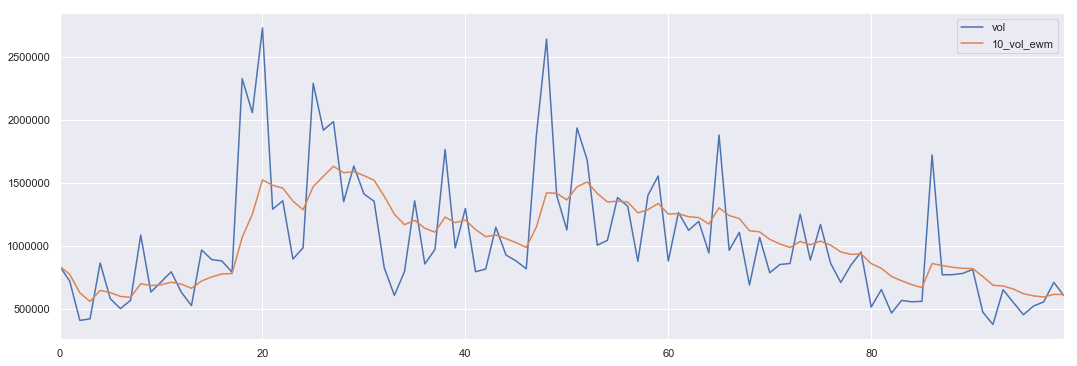

In [4]:
tickers['10_vol_ewm'] = tickers.groupby(['ts_code'])['vol'].apply(lambda x: vol_ewm(x, 10))
tickers[tickers['ts_code']=="000001.SZ"][['vol','10_vol_ewm']].plot(figsize = (18, 6))

In [5]:
# tickers_test['10_vol_ewm_rank'] = 
# df['normed_score'] = df.groupby(['ts'])[score_col].apply(lambda x: crrnt_norm_val_rank(x))
tickers['vol_rank'] = tickers.groupby(['trade_date'])['10_vol_ewm'].apply(lambda x: x.rank(ascending = False))

In [16]:
# today = str(datetime.now().date())
vol_rank_condition = tickers['vol_rank']<=100
filtered_df = tickers[(tickers['trade_date']==tickers['trade_date'].values[-1])&(vol_rank_condition)]
filtered_tickers = list(filtered_df['ts_code'].unique())

In [30]:
filtered_df.sort_values("vol_rank").head(20)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,10_vol_ewm,vol_rank
26899,000725.SZ,2019-12-17,4.38,4.83,4.35,4.75,4.39,0.36,8.2005,24691040.32,1.145603e+07,1.206477e+07,1.0
6099,000100.SZ,2019-12-17,4.33,4.60,4.29,4.45,4.33,0.12,2.7714,9242783.62,4.093959e+06,4.937033e+06,2.0
8399,000413.SZ,2019-12-17,3.21,3.54,3.20,3.54,3.22,0.32,9.9379,4872036.38,1.651850e+06,2.615685e+06,3.0
123999,002797.SZ,2019-12-17,8.42,9.10,8.33,8.57,8.49,0.08,0.9423,3746863.41,3.247328e+06,2.474052e+06,4.0
64199,002185.SZ,2019-12-17,6.94,6.94,6.76,6.87,6.96,-0.09,-1.2931,1815583.32,1.241484e+06,2.096947e+06,5.0
91099,002456.SZ,2019-12-17,16.70,17.47,16.59,16.90,16.83,0.07,0.4159,2224299.83,3.767064e+06,1.855587e+06,6.0
105299,002600.SZ,2019-12-17,11.18,11.48,11.10,11.28,11.30,-0.02,-0.1770,1841983.17,2.076248e+06,1.474615e+06,7.0
113199,002681.SZ,2019-12-17,6.36,6.50,6.20,6.35,6.35,0.00,0.0000,1341383.89,8.500721e+05,1.419700e+06,8.0
65199,002195.SZ,2019-12-17,3.16,3.27,3.14,3.26,3.14,0.12,3.8217,2311141.88,7.440391e+05,1.252526e+06,9.0
58799,002131.SZ,2019-12-17,2.25,2.27,2.21,2.26,2.24,0.02,0.8929,1440707.63,3.231807e+05,1.251319e+06,10.0


In [21]:
def MACD(df, n_fast, n_slow, n_macd): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    """
    """
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df['close'].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df['close'].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['MACD_signal'] = df['MACD'].apply(lambda x: "多头信号" if x>0 else ("空头信号" if x<0 else "空仓信号"))
#     return MACD, MACDsign, MACDdiff
    return df

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

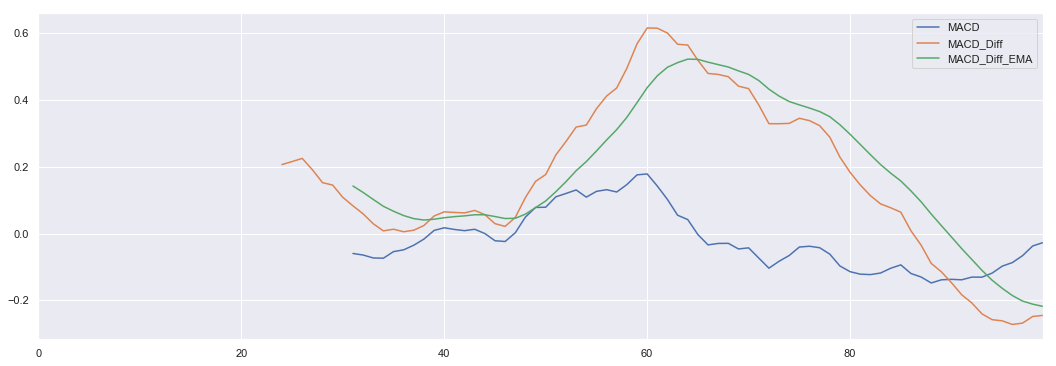

In [22]:
MACD(tickers[tickers['ts_code']=="000001.SZ"], 12, 26, 9)[['MACD','MACD_Diff','MACD_Diff_EMA']].plot(figsize = (18,6))

In [23]:
filtered_tickers

['000002.SZ',
 '000008.SZ',
 '000016.SZ',
 '000021.SZ',
 '000040.SZ',
 '000050.SZ',
 '000063.SZ',
 '000066.SZ',
 '000069.SZ',
 '000100.SZ',
 '000157.SZ',
 '000158.SZ',
 '000166.SZ',
 '000338.SZ',
 '000413.SZ',
 '000425.SZ',
 '000536.SZ',
 '000540.SZ',
 '000563.SZ',
 '000595.SZ',
 '000625.SZ',
 '000717.SZ',
 '000723.SZ',
 '000725.SZ',
 '000727.SZ',
 '000735.SZ',
 '000750.SZ',
 '000776.SZ',
 '000783.SZ',
 '000807.SZ',
 '000823.SZ',
 '000835.SZ',
 '000859.SZ',
 '000876.SZ',
 '000932.SZ',
 '000933.SZ',
 '000961.SZ',
 '002017.SZ',
 '002024.SZ',
 '002027.SZ',
 '002036.SZ',
 '002045.SZ',
 '002065.SZ',
 '002071.SZ',
 '002077.SZ',
 '002079.SZ',
 '002100.SZ',
 '002124.SZ',
 '002129.SZ',
 '002131.SZ',
 '002152.SZ',
 '002156.SZ',
 '002157.SZ',
 '002161.SZ',
 '002174.SZ',
 '002185.SZ',
 '002195.SZ',
 '002256.SZ',
 '002273.SZ',
 '002276.SZ',
 '002280.SZ',
 '002288.SZ',
 '002332.SZ',
 '002340.SZ',
 '002343.SZ',
 '002351.SZ',
 '002369.SZ',
 '002384.SZ',
 '002402.SZ',
 '002405.SZ',
 '002415.SZ',
 '0024

In [24]:
signal_record = []
for ticker in filtered_tickers:
    print("Calculating Signal for: ", ticker)
    try:
        single_ticker_df = tickers[tickers['ts_code']==ticker]
        signal_df = MACD(single_ticker_df, 12, 26, 9)
        last_signal = signal_df[['ts_code','MACD_signal']].values[-1]
        signal_record.append(last_signal)
    except:
        pass

Calculating Signal for:  000002.SZ
Calculating Signal for:  000008.SZ
Calculating Signal for:  000016.SZ
Calculating Signal for:  000021.SZ
Calculating Signal for:  000040.SZ
Calculating Signal for:  000050.SZ
Calculating Signal for:  000063.SZ
Calculating Signal for:  000066.SZ
Calculating Signal for:  000069.SZ
Calculating Signal for:  000100.SZ
Calculating Signal for:  000157.SZ
Calculating Signal for:  000158.SZ


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Calculating Signal for:  000166.SZ
Calculating Signal for:  000338.SZ
Calculating Signal for:  000413.SZ
Calculating Signal for:  000425.SZ
Calculating Signal for:  000536.SZ
Calculating Signal for:  000540.SZ
Calculating Signal for:  000563.SZ
Calculating Signal for:  000595.SZ
Calculating Signal for:  000625.SZ
Calculating Signal for:  000717.SZ
Calculating Signal for:  000723.SZ
Calculating Signal for:  000725.SZ
Calculating Signal for:  000727.SZ
Calculating Signal for:  000735.SZ
Calculating Signal for:  000750.SZ
Calculating Signal for:  000776.SZ
Calculating Signal for:  000783.SZ
Calculating Signal for:  000807.SZ
Calculating Signal for:  000823.SZ
Calculating Signal for:  000835.SZ
Calculating Signal for:  000859.SZ
Calculating Signal for:  000876.SZ
Calculating Signal for:  000932.SZ
Calculating Signal for:  000933.SZ
Calculating Signal for:  000961.SZ
Calculating Signal for:  002017.SZ
Calculating Signal for:  002024.SZ
Calculating Signal for:  002027.SZ
Calculating Signal f

In [25]:
signal_record

[array(['000002.SZ', '多头信号'], dtype=object),
 array(['000008.SZ', '多头信号'], dtype=object),
 array(['000016.SZ', '多头信号'], dtype=object),
 array(['000021.SZ', '多头信号'], dtype=object),
 array(['000040.SZ', '空头信号'], dtype=object),
 array(['000050.SZ', '多头信号'], dtype=object),
 array(['000063.SZ', '多头信号'], dtype=object),
 array(['000066.SZ', '多头信号'], dtype=object),
 array(['000069.SZ', '多头信号'], dtype=object),
 array(['000100.SZ', '多头信号'], dtype=object),
 array(['000157.SZ', '多头信号'], dtype=object),
 array(['000158.SZ', '多头信号'], dtype=object),
 array(['000166.SZ', '多头信号'], dtype=object),
 array(['000338.SZ', '多头信号'], dtype=object),
 array(['000413.SZ', '空头信号'], dtype=object),
 array(['000425.SZ', '多头信号'], dtype=object),
 array(['000536.SZ', '多头信号'], dtype=object),
 array(['000540.SZ', '多头信号'], dtype=object),
 array(['000563.SZ', '多头信号'], dtype=object),
 array(['000595.SZ', '多头信号'], dtype=object),
 array(['000625.SZ', '多头信号'], dtype=object),
 array(['000717.SZ', '多头信号'], dtype=object),
 array(['0

# 3. ETF数据

510050 - 华夏上证50ETF

ETF基金分为以下几类：

一、QDII基金：QD基金是指国内投资者对海外资本市场进行投资的一种基金。目前国内的QDII基金主要投资美股市场、港股市场，典型代表有华宝油气（162411）、标普500（513500）和香港中小（501021）等。

二、场内货币ETF：场内货币ETF指的是可以交易的货币基金。相比于普通的货币基金，此类基金在交易所上市，可以进行买卖和申赎。场内货币基金的买卖就和股票的操作一样，直接输入交易代码填写数量即可。场内货币ETF的典型代表有华宝添益（511990）、银华日利（511880）、建信添益（511660）等。

三、黄金ETF：黄金ETF指的是投资黄金的指数基金，跟踪的是现货黄金的价格波动。目前黄金ETF基金主要有四只，易方达黄金ETF(159934)、博时黄金159937、国泰黄金ETF（518800）、华安黄金ETF（518880）。

四、指数ETF：指数ETF是这四类ETF基金中数量最多、最常见的ETF金了。股民们熟悉的300ETF（510300）、创业板ETF（159915）、500ETF（510500）都是指数ETF基金。除了这些宽基指数基金外，还有跟踪行业指数的指数ETF，比如金融ETF(510230)、银行ETF（512800）、军工ETF（512660）、广发医药（159938）等。

# Chinese ETF

https://zhuanlan.zhihu.com/p/24920904

In [6]:
#抓取历史数据
def GetHistoryData(Code, BeginTime, EndTime):
    df = ts.get_k_data(Code, index = False,  start = BeginTime, end = EndTime)
    return df

df_300_hist = GetHistoryData("510300", "2010-01-01", today)
df_nas_hist = GetHistoryData("513100", "2010-01-01", today)

In [7]:
df_300_hist

,date,open,close,high,low,volume,code
0,2012-05-28,2.551,2.604,2.607,2.544,12775187.0,510300
1,2012-05-29,2.602,2.644,2.661,2.602,7149490.0,510300
2,2012-05-30,2.642,2.636,2.647,2.633,2658871.0,510300
3,2012-05-31,2.621,2.630,2.645,2.613,1781559.0,510300
4,2012-06-01,2.629,2.630,2.660,2.620,1793500.0,510300
...,...,...,...,...,...,...,...
1835,2019-12-09,3.966,3.953,3.975,3.942,2322208.0,510300
1836,2019-12-10,3.946,3.956,3.961,3.941,1869954.0,510300
1837,2019-12-11,3.902,3.900,3.904,3.883,1704989.0,510300
1838,2019-12-12,3.901,3.889,3.904,3.885,1371519.0,510300


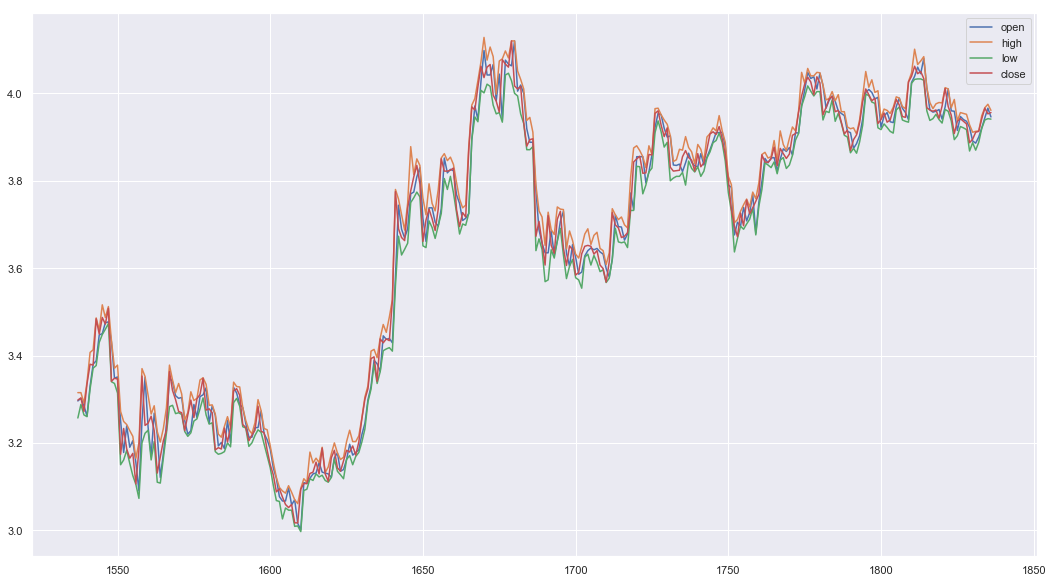

In [20]:
df_300_hist[['open','high','low','close']].tail(300).plot(figsize = (18,10))

https://zhuanlan.zhihu.com/p/24920904